In [1]:
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use("nbagg")   #подключить эти пакеты для анимации

In [40]:
#параметры сетки и объявление элементов
Tlen = 110
dt = 0.0001
nt = int(Tlen/dt)        # number of time steps
Lz = 3*np.pi       # coordinate region
Lx = 5*np.pi
dx = np.pi/16 #Lx/(nx)     # calculate space increment
dz = np.pi/16 #Lz/(nz)
nx = int(Lx/dx)        # number of grid points in x  
nz = int(Lz/dz)         # number of grid points in z
iplot = 11000

f  = np.linspace(-np.pi/2,Lx-np.pi/2, nx) # initialize space coordinates
p  = np.linspace(-Lz/2, Lz/2, nz) # initialize space coordinates
#t   = np.arange(1, nt+1)*dt  # initialize time axis

# initialization of pressure fields
# помни, что у нас nz строк (движение по p) и nx столбцов 
sp = np.zeros((nz, nx), dtype= float)
spold = np.zeros((nz, nx), dtype=float) #разве мне нужен spnew? зачем перезаписывать матрицу каждый раз?
sd2pp = np.zeros((nz, nx), dtype=float) # матрица для производной по p
sd2pf = np.zeros((nz, nx), dtype=float) # матрица для производной по f
spnew = np.zeros((nz, nx), dtype=float)

# plotting parameters
wid, hight = 6, 4

In [41]:
print("dt = ", dt,"\n","dx = ", dx,"\n", "dz =", dz,"\n", "nt = ", nt,"\n","snaps =", nt/iplot,"\n","nx = ", nx,"\n",
      "nz = ",nz,"\n")

dt =  0.0001 
 dx =  0.19634954084936207 
 dz = 0.19634954084936207 
 nt =  1100000 
 snaps = 100.0 
 nx =  80 
 nz =  48 



In [35]:
tau = 100
def fx(t):
    return np.pi*(np.tanh(2*np.pi*t/tau - np.pi)+1)
lq = 3
def H(f,p,t):
    return p**2/2 + (fx(t)-f)**2/(2*lq) + (1 - np.cos(f))
# производную для силы определили вручную
def F(f,t):
    return (fx(t)-f)/lq - np.sin(f)#-np.gradient(H(f,0))

In [36]:
def fourier_derivative(f, dx):    
    nx = np.size(f)
    # Initialize k vector up to Nyquist wavenumber 
    kmax = np.pi / dx
    dk = kmax / (nx / 2)                                   # не до конца понимаю это место.
    k = np.arange(float(nx))                               # хотя сама делала что-то похожее с hstack
    k[: int(nx/2)] = k[: int(nx/2)] * dk 
    k[int(nx/2) :] = k[: int(nx/2)] - kmax
    
    # Fourier derivative
    ff = np.fft.fft(f)
    ff = (1j*k)*ff
    df_num = np.real(np.fft.ifft(ff)) 
    return df_num       

In [37]:
# надо задать начатьное распределение
beta = 0.0276
#integ = lambda x: np.e**(-H(x,0)/beta)
Zf = integrate.quad(lambda x: np.e**(-H(x,0,0)/beta),-np.inf, np.inf)[0]
#Zf = integrate.quad(integ,-np.inf, np.inf)[0]
Zp = np.sqrt(2*np.pi*beta)               # статсуммы вроде как сходятся
def rho0(f, p):                          # функция работает как надо
    return (np.e**(-H(f,p,0)/beta))/(Zf*Zp)
beg = np.zeros((nz, nx), dtype= float) #матрица нулей для начального распределения
for i in range(nz):
    for j in range(nx):
        beg[i,j] =  rho0(p[i],f[j])

<IPython.core.display.Javascript object>


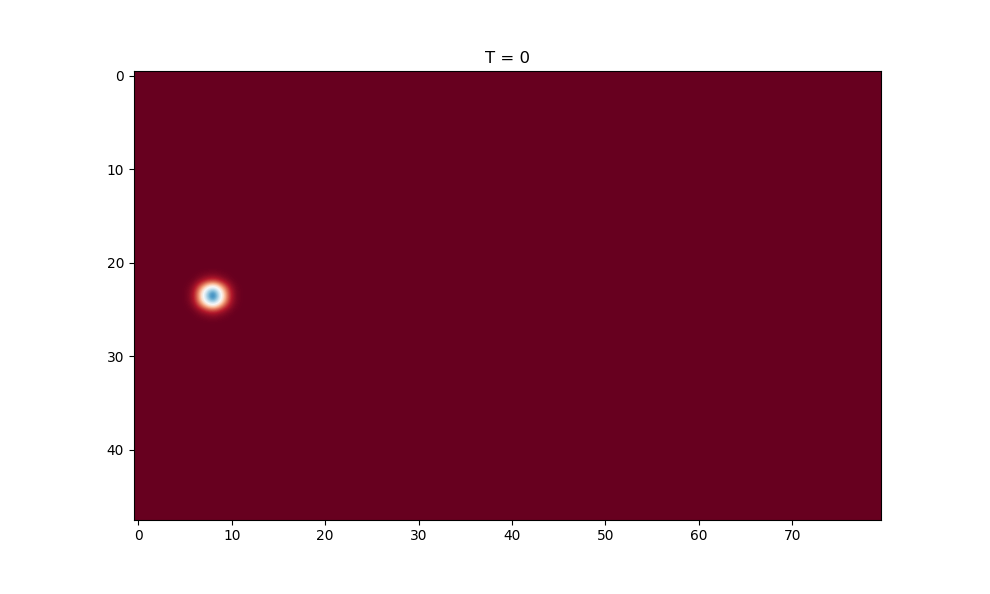

In [29]:
#это начальное распределение
fig = plt.figure(figsize=(10,6))
plt.imshow(beg, interpolation="bicubic", cmap=plt.cm.RdBu)
plt.title("T = 0")
plt.show()

In [42]:
sd2pp1 = np.zeros((nz, nx), dtype=float)
sd2pf1 = np.zeros((nz, nx), dtype=float)
for j in np.arange(nx):           
    sd2pp[:,j] = F(f,dt)[j]*fourier_derivative(beg[:,j].T, dz) #F(f)[j]*fourier_derivative(sp[:,j].T, dx) #jй столбец, по p
for i in np.arange(nz):           
    sd2pf[i,:] = p[i]*fourier_derivative(beg[i,:], dx) #p[i]*fourier_derivative(sp[i,:], dx) #iя ст рока, по q
sp = beg - dt*(sd2pp1 + sd2pf1)

<IPython.core.display.Javascript object>


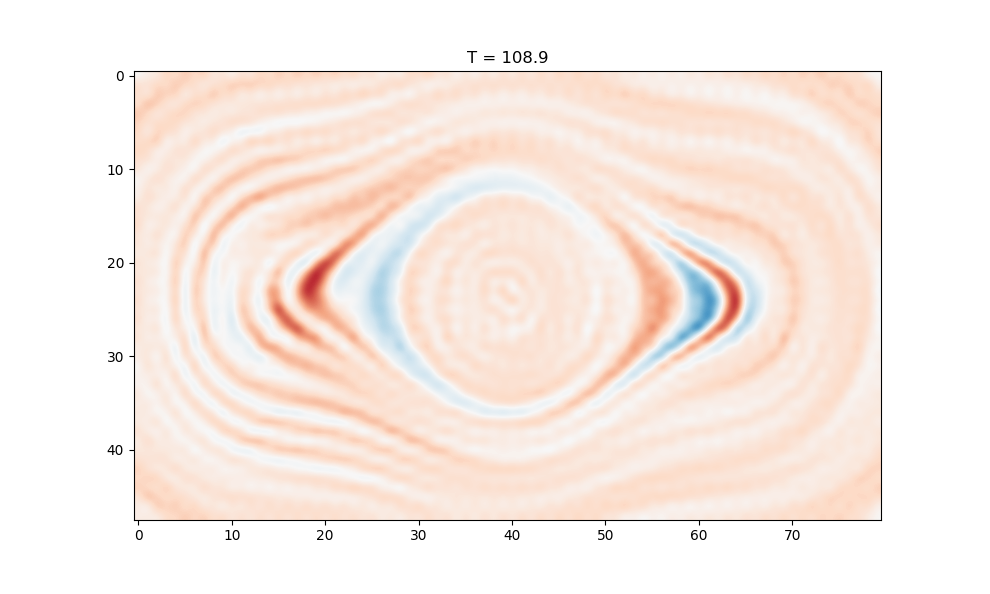

In [43]:
# Initialize animated plot
# ---------------------------------------------------------------
fig = plt.figure(figsize=(10,6))
plt.imshow(sp, interpolation="bicubic", cmap=plt.cm.RdBu)
plt.title('Fourier Method', size=14)
#plt.colorbar()
plt.ion()   # set interective mode
plt.show()

In [44]:
spold = beg #в нулевой момент времнени плотность равна НУ

for it in range(2,nt):
   
    # ----------------------------------------
    # Fourier Pseudospectral Method
    # ----------------------------------------
    # space derivative
    
    for j in np.arange(nx):           
        sd2pp[:,j] = F(f,it*dt)[j]*fourier_derivative(sp[:,j].T, dz) #F(f)[j]*fourier_derivative(sp[:,j].T, dx) #jй столбец, по p
    for i in np.arange(nz):           
        sd2pf[i,:] = p[i]*fourier_derivative(sp[i,:], dx) #p[i]*fourier_derivative(sp[i,:], dx) #iя ст рока, по q
 
        
    # Time Extrapolation
    # Time Extrapolation  
    spnew = spold - 2*dt*(sd2pp + sd2pf)    
    #sp = spnew # Time levels
    
    if not it % iplot:                    
        # Display Solution
        # -------------------------------------- 
        plt.imshow(sp, interpolation="bicubic", cmap=plt.cm.RdBu) 
        plt.title("T = {}".format(it*dt))
        plt.gcf().canvas.draw()
    
    spold = sp
    sp = spnew

In [45]:
# sp все еще по определеннию плотность веротности
print("интеграл по поверхности новой ф-ии =",np.sum(sp)*dx*dz)

интеграл по поверхности новой ф-ии = 0.9668399886392328


In [46]:
# sp все еще по определеннию плотность веротности
print("интеграл по поверхности нач распр-я =",np.sum(beg)*dx*dz)

интеграл по поверхности нач распр-я = 0.9668399886392285
